In [6]:
# Course : CS 513 - Knowledge Discovery and Data Mining
# Group Members: Branden Bulatao, Joseph Faustino, Natalie Fortes, Isabel Sutedjo
# Id : 20005971, 20006114, 20006007, 20006618
# Purpose : Music Happiness Predictor - Predicts the happiness of music tracks based on various features.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


# Load dataset
df = pd.read_csv('./dataset.csv')

# Drop unnamed and nulls
df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df.dropna(inplace=True)

# Convert valence to binary: 0 = sad, 1 = happy
df['valence'] = df['valence'].map(lambda x: 0 if x < 0.5 else 1)

# Convert 'explicit' to int
df['explicit'] = df['explicit'].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['key', 'time_signature', 'track_genre'], drop_first=True)

# Define target and drop non-feature columns
y = df['valence']
X = df.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'valence'])

# Identify numeric features to scale
numeric_features = ['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
                    'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo']

# All other features (binary or one-hot) are left as-is
non_scaled_features = [col for col in X.columns if col not in numeric_features]

# ColumnTransformer for selective scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('pass', 'passthrough', non_scaled_features)
    ]
)

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

# Reconstruct a DataFrame (optional, for inspection/debugging)
X_processed = pd.DataFrame(X_processed, columns=numeric_features + non_scaled_features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=42)
X

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,73,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,...,False,False,False,False,False,False,False,False,False,False
1,55,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,...,False,False,False,False,False,False,False,False,False,False
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,...,False,False,False,False,False,False,False,False,False,False
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,...,False,False,False,False,False,False,False,False,False,False
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,...,False,False,False,False,False,False,False,False,False,True
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,...,False,False,False,False,False,False,False,False,False,True
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,...,False,False,False,False,False,False,False,False,False,True
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,...,False,False,False,False,False,False,False,False,False,True


In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Model 7: ANN
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=10000, random_state=42)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: \n{accuracy * 100:.2f}%\n")

report = classification_report(y_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(report)

print("Confusion Matrix:")
print(cm)

Accuracy: 
77.78%

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     18571
           1       0.77      0.73      0.75     15629

    accuracy                           0.78     34200
   macro avg       0.78      0.77      0.78     34200
weighted avg       0.78      0.78      0.78     34200

Confusion Matrix:
[[15167  3404]
 [ 4194 11435]]


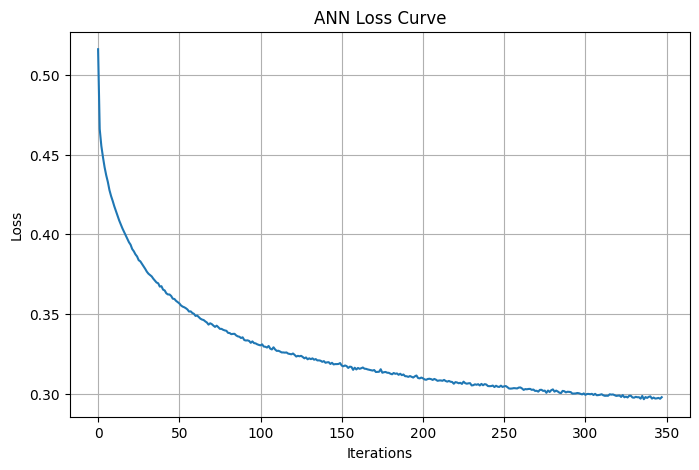

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(mlp.loss_curve_)
plt.title("ANN Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

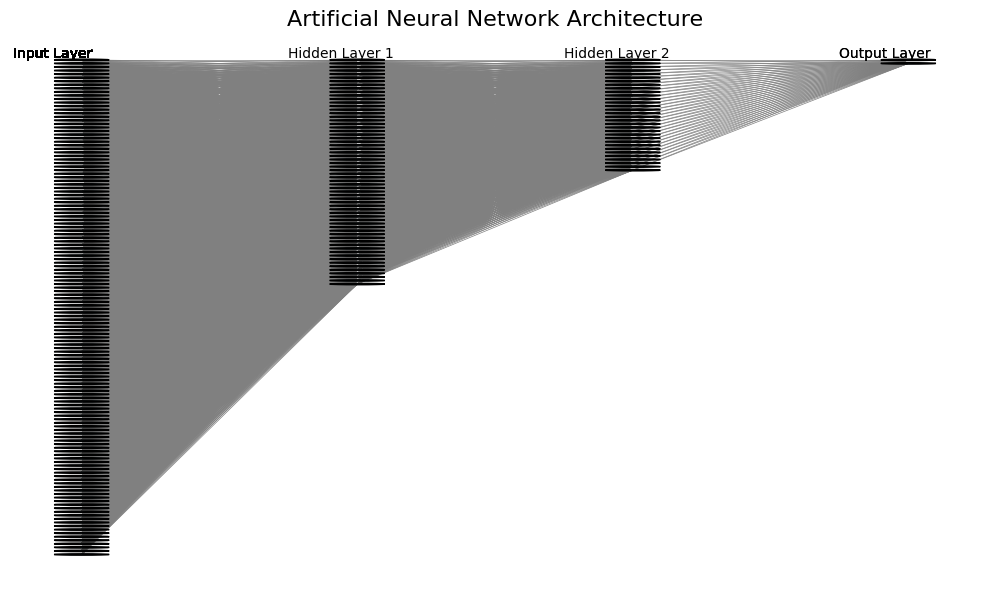

In [4]:
import matplotlib.pyplot as plt

def draw_ann(layer_sizes, node_radius=0.2):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.set_title("Artificial Neural Network Architecture", fontsize=16)

    n_layers = len(layer_sizes)
    v_spacing = 1
    h_spacing = 2
    max_nodes = max(layer_sizes)

    positions = {}

    for i, n_nodes in enumerate(layer_sizes):
        layer_x = i * h_spacing
        top_y = (max_nodes - 1) * v_spacing / 2
        positions[i] = []
        for j in range(n_nodes):
            y = top_y - j * v_spacing
            circle = plt.Circle((layer_x, y), radius=node_radius, fill=True, color='skyblue', ec='black', zorder=3)
            ax.add_patch(circle)
            positions[i].append((layer_x, y))

            # Add labels to layers
            if i == 0:
                ax.text(layer_x - 0.5, top_y + 0.5, "Input Layer", fontsize=10)
            elif i == n_layers - 1:
                ax.text(layer_x - 0.5, top_y + 0.5, "Output Layer", fontsize=10)
            elif j == 0:
                ax.text(layer_x - 0.5, top_y + 0.5, f"Hidden Layer {i}", fontsize=10)

    # Draw connections
    for i in range(n_layers - 1):
        for (x1, y1) in positions[i]:
            for (x2, y2) in positions[i + 1]:
                ax.plot([x1, x2], [y1, y2], 'gray', linewidth=0.5, zorder=1)

    plt.tight_layout()
    plt.show()

input_size = X_train.shape[1]
output_size = len(set(y_train))  # number of classes

draw_ann([input_size, 64, 32, output_size])

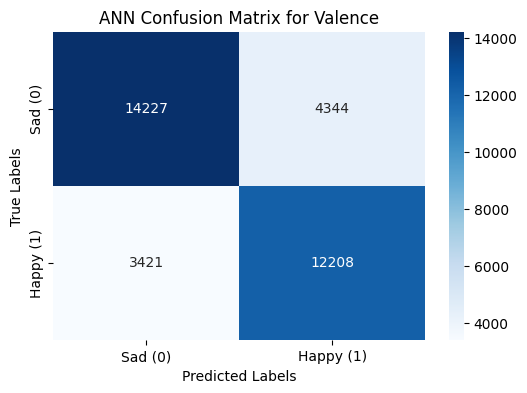

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create the heatmap
plt.figure(figsize=(6, 4))
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt="g", cmap="Blues", ax=ax)

# Labels, title, and ticks
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("ANN Confusion Matrix for Valence")
ax.xaxis.set_ticklabels(["Sad (0)", "Happy (1)"])
ax.yaxis.set_ticklabels(["Sad (0)", "Happy (1)"])

plt.show()